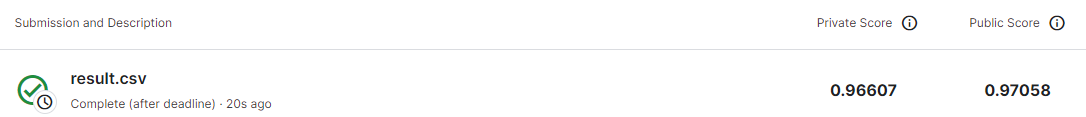

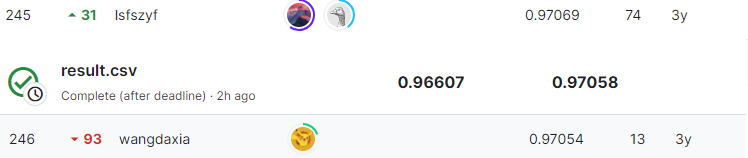

In [20]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf


### 이미지 전처리

In [21]:
# 이미지의 크기를 설정
IMAGE_SIZE = (300, 300)

# 이미지 파일과 데이터 파일의 경로 설정
IMAGE_PATH = "./plant-pathology-2020-fgvc7/images/"
TEST_PATH = "./plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "./plant-pathology-2020-fgvc7/aug_train.csv"

# 테스트 데이터와 훈련 데이터 파일을 읽어옴
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

# 이미지를 로드하는 함수 정의
def load_image(image_id):
    # 이미지 파일의 경로를 생성
    file_path = image_id + ".jpg"
    # OpenCV를 사용하여 이미지 파일을 읽어옴
    image = cv2.imread(IMAGE_PATH + file_path)

    # 이미지 크기를 IMAGE_SIZE로 조정
    image = cv2.resize(image, IMAGE_SIZE)

    # 이미지의 색 공간을 BGR에서 RGB로 변환
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 훈련 데이터의 "image_id" 열에 대해 load_image 함수를 적용하여 이미지들을 로드함
images = train_data["image_id"].apply(load_image)


In [22]:
# 이미지들을 numpy 배열로 변환하여 하나의 배열로 스택(stack)함
images = np.stack(images)

# 훈련 데이터의 레이블 열인 "healthy", "multiple_diseases", "rust", "scab"에 해당하는 값들을 가져와서 배열로 변환
labels = train_data[["healthy", "multiple_diseases", "rust", "scab"]].values

In [26]:
# 배치 크기 설정
BATCH_SIZE = 4

# 학습률 설정
LEARNING_RATE = 0.00025

# K_NUM 설정
###### K FOLD를 반복문으로 연속 실행하면 모델 교체 순간에 OOM이 발생해서 수동으로 5번 작동하도록 만들었습니다!!!
K_NUM = 0

# EfficientNetV2B3 모델을 가져와서 efmodel 변수에 저장
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B3
efmodel = EfficientNetV2B3(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE[1], IMAGE_SIZE[0], 3))

# Sequential 모델 생성
model = Sequential()

# efmodel을 Sequential 모델에 추가
model.add(efmodel)

# GlobalAveragePooling2D 레이어 추가
model.add(GlobalAveragePooling2D())

# Dense 레이어 추가
model.add(Dense(4, activation='softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 10, 10, 1536)     12930622  
 al)                                                             
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 4)                 6148      
                                                                 
Total params: 12,936,770
Trainable params: 12,827,554
Non-trainable params: 109,216
_________________________________________________________________


In [27]:
# labels 배열에서 가장 큰 값의 인덱스를 추출하여 y_categorical 변수에 저장
y_categorical = np.argmax(labels, axis=1)

# K-fold 교차 검증을 위한 변수 설정
k = 5  # 폴드 수
stratified_kfold = StratifiedKFold(n_splits=k)

# history 변수 초기화
history = None

# K-fold 교차 검증을 수행하는 반복문
for i, (train_indices, test_indices) in enumerate(stratified_kfold.split(images, y_categorical)):
     ###### K FOLD를 반복문으로 연속 실행하면 모델 교체 순간에 OOM이 발생해서 수동으로 5번 작동하도록 만들었습니다!!!
    if i != K_NUM:
        continue
    
    # 훈련 데이터와 검증 데이터를 나눔
    train_images, val_images = images[train_indices], images[test_indices]
    train_labels, val_labels = labels[train_indices], labels[test_indices]

    # 데이터 증강을 위한 ImageDataGenerator 설정
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rotation_range=15,
        shear_range=0.2,
        zoom_range=[0.9, 1.1],
        brightness_range=[0.8, 1],
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator()

    # 훈련 및 검증 데이터에 대한 데이터 생성기 생성
    train_generator = train_datagen.flow(x=train_images, y=train_labels, batch_size=BATCH_SIZE, shuffle=True)
    val_generator = train_datagen.flow(x=val_images, y=val_labels, batch_size=BATCH_SIZE)

    # 모델 저장 경로 및 파일명 설정
    modelpath = f'./model/train14E/kfold{i}/'
    modelname = 'best.hdf5'

    # 검증 손실(val_loss)을 모니터링하고, 최상의 모델만 저장하는 ModelCheckpoint 콜백 생성
    checkpointer = ModelCheckpoint(filepath=modelpath+modelname, monitor='val_loss', verbose=1, save_best_only=True)

    # 검증 손실(val_loss)을 모니터링하고, 학습률을 조절하는 ReduceLROnPlateau 콜백 생성
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

    # 모델을 훈련
    history = model.fit(train_generator, epochs=50, verbose=1, callbacks=[checkpointer, reduce_lr], validation_data=val_generator)

Epoch 1/100
364/364 [==============================] - ETA: 0s - loss: 0.6292 - accuracy: 0.7905
Epoch 1: val_loss improved from inf to 0.36463, saving model to ./model/train13/kfold0\best.hdf5
364/364 [==============================] - 110s 277ms/step - loss: 0.6292 - accuracy: 0.7905 - val_loss: 0.3646 - val_accuracy: 0.8904 - lr: 2.5000e-04
Epoch 2/100
364/364 [==============================] - ETA: 0s - loss: 0.3664 - accuracy: 0.8887
Epoch 2: val_loss improved from 0.36463 to 0.26226, saving model to ./model/train13/kfold0\best.hdf5
364/364 [==============================] - 29s 79ms/step - loss: 0.3664 - accuracy: 0.8887 - val_loss: 0.2623 - val_accuracy: 0.9178 - lr: 2.5000e-04
Epoch 3/100
364/364 [==============================] - ETA: 0s - loss: 0.2959 - accuracy: 0.9121
Epoch 3: val_loss improved from 0.26226 to 0.25067, saving model to ./model/train13/kfold0\best.hdf5
364/364 [==============================] - 30s 81ms/step - loss: 0.2959 - accuracy: 0.9121 - val_loss: 0.250